# Prévisions météo en Australie
### Consignes de l'itération2 : "Modélisation"

	1. Ajouter les coordonnées géographiques (Australia Cities Database | Simplemaps.com)
	2. sélection des variables avec le test du chi2
	3. Extraction du jeu de données final
	4. Tableau des performances  des algo avec et sans rééquilibrage
	5. Choisir une seconde stratégie pour l’itération 2 parmi les suivantes
	• Classification des villes par clustering (faire le rapprochement avec le climat)
	• Deep Learning
	• Séries Temporelles

**Synchro** lundi 5 septembre à 17h

**Deadline** dimanche 11 septembre

# Récupération des librairies

In [355]:
# récupération des librairies
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time, datetime

# import scikitplot as skplt # impossible d'importer scikitplot

# from google.colab import files

from sklearn import ensemble, linear_model, model_selection, neighbors, preprocessing, svm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler

# Préparation des données

In [356]:
# récupération du jeu de données
df = pd.read_csv('weatherAUS.csv')
# df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datascientest/Meteo/weatherAUS.csv')

df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [357]:
# taille du DataFrame
print("Nombre d'observations : {} \n Nombre de variables : {}".format(df.shape[0], df.shape[1]))

Nombre d'observations : 145460 
 Nombre de variables : 23


In [358]:
# suppression des doublons
df.drop_duplicates(inplace=True)

In [359]:
# détection des valeurs manquantes sur tout le dataframe
df.isna().sum().sort_values(ascending=False)

Sunshine         69835
Evaporation      62790
Cloud3pm         59358
Cloud9am         55888
Pressure9am      15065
Pressure3pm      15028
WindDir9am       10566
WindGustDir      10326
WindGustSpeed    10263
Humidity3pm       4507
WindDir3pm        4228
Temp3pm           3609
RainTomorrow      3267
Rainfall          3261
RainToday         3261
WindSpeed3pm      3062
Humidity9am       2654
Temp9am           1767
WindSpeed9am      1767
MinTemp           1485
MaxTemp           1261
Location             0
Date                 0
dtype: int64

In [360]:
# suppression des valeurs manquantes pour "RainToday" et "RainTomorrow"
df.dropna(subset=['RainTomorrow', 'RainToday'], inplace=True)

In [361]:
# taille du DataFrame
print("Nombre d'observations : {} \n Nombre de variables : {}".format(df.shape[0], df.shape[1]))

Nombre d'observations : 140787 
 Nombre de variables : 23


In [362]:
# définition de nouvelles variables
df['Temp_Delta_MinMax'] = df['MaxTemp'] - df['MinTemp']
df['Humidity_Delta'] = df['Humidity3pm'] - df['Humidity9am']

In [363]:
# encodage des variables qualitatives binaires
df['RainToday'].replace({'No':0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No':0, 'Yes': 1}, inplace = True)

df['RainToday'] = df['RainToday'].astype('int64')
df['RainTomorrow'] = df['RainTomorrow'].astype('int64')

In [364]:
# corrélations avec la variable cible
df.corr()['RainTomorrow'].sort_values(ascending=False)

RainTomorrow         1.000000
Humidity3pm          0.447834
Cloud3pm             0.382418
Cloud9am             0.316592
RainToday            0.313097
Humidity_Delta       0.270296
Humidity9am          0.257727
Rainfall             0.239032
WindGustSpeed        0.234285
WindSpeed9am         0.089803
WindSpeed3pm         0.086762
MinTemp              0.084322
Temp9am             -0.025447
Evaporation         -0.119133
MaxTemp             -0.159405
Temp3pm             -0.192747
Pressure3pm         -0.228192
Pressure9am         -0.248253
Temp_Delta_MinMax   -0.337845
Sunshine            -0.451820
Name: RainTomorrow, dtype: float64

In [365]:
# suppression des variables les moins corrélées à la variable cible (i.e. dans l'intervalle [-0.2, 0.2])
df.drop(['WindSpeed9am', 'WindSpeed3pm', 'MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Evaporation'], axis = 1, inplace = True)

In [366]:
# suppression de la date car ni l'année, le mois, la semaine ou la journée ne sont pas très corrélées avec la variable cible
df.drop(columns=['Date'], inplace=True)

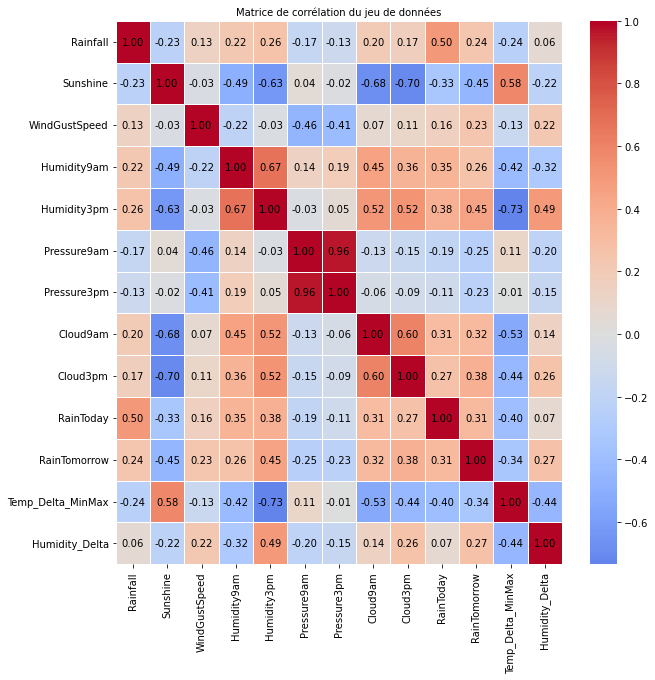

In [367]:
# création de la matrice de corrélation
fig, ax = plt.subplots(figsize=(10,10))
annot_kws={'fontsize':10,  
           'color':"k", 
           'verticalalignment':'center'}
sns.heatmap(df.corr(), linewidths=0.5, annot=True, annot_kws=annot_kws, fmt=".2f", ax=ax, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation du jeu de données', fontsize=10);

- Pressure9am and Pressure3pm sont très fortement corrélées (0.96)
- Humidity9am and Humidity3pm sont très corrélées (0.66)
- Cloud9am et Cloud3pm sont très corrélées (0.60)

In [368]:
# suppression de la variable "Pressure3pm", moins corrélées à la variable cible que "Pressure9am"
df.drop(columns=['Pressure3pm'], inplace=True)

In [369]:
# suppression de la variable "Humidity9am", moins corrélées à la variable cible que "Humidity3pm"
df.drop(columns=['Humidity9am'], inplace=True)

In [370]:
# suppression de la variable "Cloud9am", moins corrélées à la variable cible que "Cloud3pm"
df.drop(columns=['Cloud9am'], inplace=True)

In [371]:
# détection des valeurs manquantes sur tout le dataframe
df.isna().sum().sort_values(ascending=False)

Sunshine             66805
Cloud3pm             56094
Pressure9am          13743
WindDir9am            9660
WindGustDir           9163
WindGustSpeed         9105
Humidity_Delta        4019
WindDir3pm            3670
Humidity3pm           3501
Temp_Delta_MinMax      701
Location                 0
Rainfall                 0
RainToday                0
RainTomorrow             0
dtype: int64

In [372]:
# suppression des variables "Sunshine" et "Cloud3pm" qui contiennent trop de valeurs manquantes 
df.drop(columns=['Sunshine', 'Cloud3pm'], inplace=True)

In [373]:
# récupération des variables quantitatives
num_features = [col for col in df.columns if df[col].dtype != 'O']
num_data = df.select_dtypes(include='number')

print("Variables quantitatives: {}".format(num_features),'\n')
print("Nombre de variables quantitatives: {}".format(len(num_features)))

Variables quantitatives: ['Rainfall', 'WindGustSpeed', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow', 'Temp_Delta_MinMax', 'Humidity_Delta'] 

Nombre de variables quantitatives: 8


In [374]:
# cardinalité
for feature in num_features:
    print("Cardinalité de '{}': {}".format(feature, len(df[feature].unique())))

Cardinalité de 'Rainfall': 679
Cardinalité de 'WindGustSpeed': 68
Cardinalité de 'Humidity3pm': 102
Cardinalité de 'Pressure9am': 546
Cardinalité de 'RainToday': 2
Cardinalité de 'RainTomorrow': 2
Cardinalité de 'Temp_Delta_MinMax': 1049
Cardinalité de 'Humidity_Delta': 160


In [375]:
# suppression de la variable "RainToday" qui ne contient que deux modalités et donc qui se comporte plutôt comme une variable qualitative 
df.drop(columns=['RainToday'], inplace=True)

In [376]:
# mise à jour de la liste des colonnes du DataFrame
num_features = [col for col in df.columns if df[col].dtype != 'O']

In [377]:
# récupération des variables qualitatives
cat_features = [col for col in df.columns if df[col].dtype == 'O']
cat_data = df.select_dtypes(include = 'O')

print("Variables qualitatives: ", cat_features,'\n')
print("Nombre de variables qualitatives: ", len(cat_features))

Variables qualitatives:  ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'] 

Nombre de variables qualitatives:  4


In [378]:
# cardinalité
for feature in cat_features:
    print("Cardinalité de '{}': {}".format(feature, len(df[feature].unique())))

Cardinalité de 'Location': 49
Cardinalité de 'WindGustDir': 17
Cardinalité de 'WindDir9am': 17
Cardinalité de 'WindDir3pm': 17


In [379]:
# suppression des variables "WindGustDir", "WindDir9am" et "WindDir3pm" pour ne garder que les variables quantitatives
df.drop(columns=['WindGustDir', 'WindDir9am', 'WindDir3pm'], inplace=True)

In [380]:
# remplacement des valeurs manquantes en utilisant le mode
# for feat in cat_features :
#     df[feat].fillna(df[feat].mode()[0], inplace=True)

In [381]:
# transformation des variables qualitatives en variables numériques (Olivier)
# for column in cat_features:
#    l = df[column].value_counts().index.tolist() 
#    mapping = {x:y for x,y in zip(l, range(len(l)))}
#    df[column] = df[column].map(mapping) 

In [382]:
# dichotomisation (one hot encoding)
# onehot_features = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

# def one_hot_encode(df, cat, prefix):
#     for col, pref in zip(cat, prefix):
#         dummy = pd.get_dummies(df[col], prefix=pref)
#         df = pd.concat([df, dummy], axis=1)
#         df = df.drop(col, axis=1)
#     return df

# df = one_hot_encode(df, onehot_features, ['wgd', 'wd9', 'wd3'])

In [383]:
# calcul des valeurs délimitant les outliers et remplacement des outliers par la valeur des limites 
for feature in ['WindGustSpeed','Humidity3pm','Pressure9am','Rainfall','Temp_Delta_MinMax','Humidity_Delta']:
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    IQR = q3 - q1
    lower_limit = q1 - (IQR*1.5)
    upper_limit = q3 + (IQR*1.5)
    df.loc[df[feature] < lower_limit, feature] = lower_limit
    df.loc[df[feature] > upper_limit, feature] = upper_limit

In [384]:
# remplacement des valeurs manquantes en utilisant la moyenne
for feat in num_features :
    df[feat].fillna(df[feat].mean(), inplace=True)

In [385]:
# Vérification des valeurs manquantes sur tout le DataFrame
df.isnull().sum().sum()

0

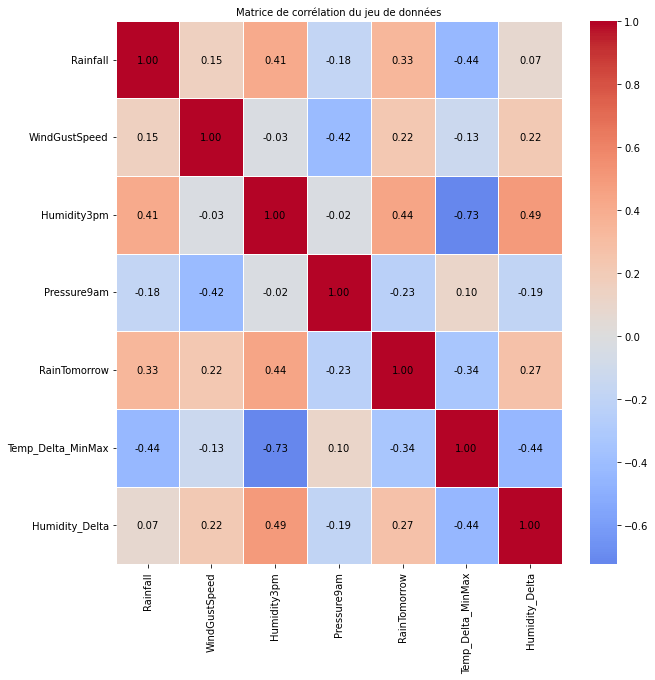

In [386]:
# création de la matrice de corrélation
fig, ax = plt.subplots(figsize=(10,10))
annot_kws={'fontsize':10,  
           'color':"k", 
           'verticalalignment':'center'}
sns.heatmap(df.corr(), linewidths=0.5, annot=True, annot_kws=annot_kws, fmt=".2f", ax=ax, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation du jeu de données', fontsize=10);

# Ajouter les coordonnées géographiques

In [387]:
# récupération des coordonnées géographiques
au = pd.read_csv('au.csv')

au.head()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Sydney,-33.8650,151.2094,Australia,AU,New South Wales,admin,5312163,4840600
1,Melbourne,-37.8136,144.9631,Australia,AU,Victoria,admin,5078193,4529500
2,Brisbane,-27.4678,153.0281,Australia,AU,Queensland,admin,2514184,2360241
3,Perth,-31.9522,115.8589,Australia,AU,Western Australia,admin,2059484,2039200
4,Adelaide,-34.9289,138.6011,Australia,AU,South Australia,admin,1345777,1295714


In [388]:
# On renomme la colonne 'city' en 'Location' pour faire la fusion
au = au.rename(columns = {'city':'Location'})

In [389]:
# Jointure à gauche entre df et au sur la colonne 'Location'
df = df.merge(right = au[['Location','lat', 'lng']], on = 'Location', how = 'left')
df[['lat', 'lng']].isna().sum()

lat    65554
lng    65554
dtype: int64

In [390]:
df[df['lat'].isna()]['Location'].value_counts()

AliceSprings        3025
MountGambier        3022
MelbourneAirport    3009
PerthAirport        3009
SydneyAirport       3001
Watsonia            2990
Woomera             2984
Tuggeranong         2959
WaggaWagga          2958
NorfolkIsland       2944
SalmonGums          2941
CoffsHarbour        2940
Dartmoor            2939
Witchcliffe         2924
GoldCoast           2924
NorahHead           2888
BadgerysCreek       2877
MountGinini         2816
Walpole             2770
PearceRAAF          2646
Williamtown         2376
Nhil                1565
Katherine           1545
Uluru               1502
Name: Location, dtype: int64

In [391]:
np.sort(au.Location.unique())

array(['Aberdare', 'Adelaide', 'Albany', 'Albury', 'Aldgate', 'Alexandra',
       'Alice Springs', 'Alstonville', 'Andergrove', 'Angle Vale',
       'Anglesea', 'Anna Bay', 'Appin', 'Ararat', 'Armidale', 'Atherton',
       'Australind', 'Ayr', 'Bacchus Marsh', 'Bairnsdale', 'Ballan',
       'Ballarat', 'Ballina', 'Bannockburn', 'Banora Point', 'Bargara',
       'Bargo', 'Barwon Heads', 'Batemans Bay', 'Bathurst', 'Bay View',
       'Beachmere', 'Beaconsfield Upper', 'Beaudesert', 'Beechworth',
       'Beerwah', 'Bega', 'Bellbrae', 'Bellingen', 'Benalla', 'Bendigo',
       'Bentley', 'Berri', 'Berry', 'Biloela', 'Blackheath', 'Blackwater',
       'Blaxland', 'Blayney', 'Bli Bli', 'Bogangar', 'Bohle Plains',
       'Bomaderry', 'Bongaree', 'Bonny Hills', 'Bonville', 'Boonah',
       'Bordertown', 'Boulder', 'Bowen', 'Bowral', 'Boyne Island',
       'Bridgetown', 'Bridgewater', 'Brisbane', 'Broadford',
       'Broken Hill', 'Broome', 'Bucasia', 'Bullsbrook', 'Bunbury',
       'Bundaberg',

In [392]:
df['Location'] = df['Location'].replace(to_replace = ['AliceSprings', 'MountGambier', 'GoldCoast', 'CoffsHarbour','Williamtown'],
                                    value= ['Alice Springs', 'Mount Gambier', 'Gold Coast', 'Coffs Harbour', 'Williamstown'])

In [393]:
df.drop(columns=['lat', 'lng'], inplace=True)

In [394]:
# Jointure à gauche entre df et au sur la colonne 'Location'
df = df.merge(right = au[['Location','lat', 'lng']], on = 'Location', how = 'left')
df[['lat', 'lng']].isna().sum()

lat    51267
lng    51267
dtype: int64

In [399]:
df.dropna(inplace=True)

# Classification des villes par clustering

In [408]:
df.columns

Index(['Location', 'Rainfall', 'WindGustSpeed', 'Humidity3pm', 'Pressure9am',
       'RainTomorrow', 'Temp_Delta_MinMax', 'Humidity_Delta', 'lat', 'lng'],
      dtype='object')

In [409]:
# Variables climatiques
var_climat = df.columns[1:-2]
var_climat

Index(['Rainfall', 'WindGustSpeed', 'Humidity3pm', 'Pressure9am',
       'RainTomorrow', 'Temp_Delta_MinMax', 'Humidity_Delta'],
      dtype='object')

In [410]:
clust = df.groupby(['Location']).mean()[var_climat]

,Rainfall,WindGustSpeed,Humidity3pm,Pressure9am,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta
Location,,,,,,,
Adelaide,0.478212,36.503654,44.769949,1018.747834,0.216887,10.340346,-15.022966
Albany,0.642056,39.776750,63.754811,1018.297134,0.297397,7.179369,-8.870847
Albury,0.444199,32.891412,47.884586,1018.367268,0.205617,13.114725,-26.257224
Alice Springs,0.173157,40.463161,24.080925,1016.710901,0.080000,16.118163,-15.593090
Ballarat,0.568777,44.724848,59.050131,1017.897062,0.258204,10.913820,-22.875258
Bendigo,0.415710,38.807652,46.489257,1018.031806,0.185149,13.013859,-24.117003
Brisbane,0.482822,28.246750,53.875812,1018.257248,0.225096,10.030772,-10.162259
Cairns,0.679926,38.081209,61.658907,1014.167915,0.315452,8.350555,-8.247638
Canberra,0.396767,39.918448,45.864607,1018.905803,0.183715,14.117555,-27.036854


In [411]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

clust = pd.DataFrame(scaler.fit_transform(clust), columns=clust.columns, index = clust.index)

,Rainfall,WindGustSpeed,Humidity3pm,Pressure9am,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta
Location,,,,,,,
Adelaide,0.488586,0.454427,0.494120,0.975062,0.477031,0.397631,0.526761
Albany,0.751004,0.634565,0.947540,0.910973,0.757592,0.068081,0.763086
Albury,0.434110,0.255624,0.568508,0.920946,0.437755,0.686875,0.095211
Alice Springs,0.000000,0.672343,0.000000,0.685412,0.000000,1.000000,0.504860
Ballarat,0.633638,0.906889,0.835177,0.854083,0.621011,0.457418,0.225125


In [414]:
# Importation de la fonction cdist du package scipy.spatial.distance
from scipy.spatial.distance import cdist

# Liste des nombre de clusters
range_n_clusters = range(2, 12) 

# Initialisation de la liste de distorsions
distorsions = []

# Calcul des distorsions pour les différents modèles
for n_clusters in range_n_clusters:
    
    # Initialisation d'un cluster ayant un pour nombre de clusters n_clusters
    cluster = KMeans(n_clusters = n_clusters)
    
    # Apprentissage des données suivant le cluster construit ci-dessus
    cluster.fit(clust)
    
    # Ajout de la nouvelle distorsion à la liste des données
    distorsions.append(sum(np.min(cdist(clust, cluster.cluster_centers_, 'euclidean'), axis=1)) / np.size(clust, axis = 0))

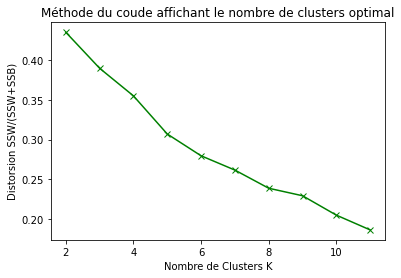

In [415]:
# Visualisation des distorsions en fonction du nombre de clusters
plt.plot(range_n_clusters, distorsions, 'gx-')
plt.xlabel('Nombre de Clusters K')
plt.ylabel('Distorsion SSW/(SSW+SSB)')
plt.title('Méthode du coude affichant le nombre de clusters optimal')
plt.show()

In [416]:
# Algorithme de K-means
kmeans = KMeans(n_clusters = 5)
kmeans.fit(clust)

# Centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

In [454]:
clust['city_cluster']=labels

In [458]:
clust=clust.reset_index()

In [463]:
# Jointure à gauche entre transactions et customer sur la colonne 'cust_id'
df=df.merge(right = clust[['Location', 'city_cluster']], on = 'Location', how = 'left')

In [465]:
df.drop(columns=['Location'], inplace=True)

In [466]:
df.head()

,Rainfall,WindGustSpeed,Humidity3pm,Pressure9am,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta,lat,lng,city_cluster
0,0.6,44.0,22.0,1007.7,0,9.5,-49.0,-36.0806,146.9158,4
1,0.0,44.0,25.0,1010.6,0,17.7,-19.0,-36.0806,146.9158,4
2,0.0,46.0,30.0,1007.6,0,12.8,-8.0,-36.0806,146.9158,4
3,0.0,24.0,16.0,1017.6,0,18.8,-29.0,-36.0806,146.9158,4
4,1.0,41.0,33.0,1010.8,0,14.8,-49.0,-36.0806,146.9158,4


## Sauvegarde du jeu de données

In [ ]:
df.to_csv('weatherAUS_preprocessed.csv')

# Modèles de classification

In [ ]:
# récupération du jeu de données sauvegardé
df = pd.read_csv('weatherAUS_preprocessed.csv', index_col=0)
df.head()

,Rainfall,WindGustSpeed,Humidity3pm,Pressure9am,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta
0,0.6,44.0,22.0,1007.7,0,9.5,-49.0
1,0.0,44.0,25.0,1010.6,0,17.7,-19.0
2,0.0,46.0,30.0,1007.6,0,12.8,-8.0
3,0.0,24.0,16.0,1017.6,0,18.8,-29.0
4,1.0,41.0,33.0,1010.8,0,14.8,-49.0


In [ ]:
# séparation des données en une matrice de données et en un vecteur cible
data = df.drop(columns=['RainTomorrow'])
target = df['RainTomorrow']

In [ ]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state=123)

In [ ]:
# distribution de la variable cible dans l'ensemble d'entraînement
y_train.value_counts()

0    87678
1    24951
Name: RainTomorrow, dtype: int64

In [ ]:
# distribution de la variable cible dans l'ensemble de test
y_test.value_counts()

0    21908
1     6250
Name: RainTomorrow, dtype: int64

In [ ]:
# oversampling des données
# rOs = RandomOverSampler()
# X_ro, y_ro = rOs.fit_resample(X_train, y_train)
# print("Classes échantillon oversampled :", dict(pd.Series(y_ro).value_counts()))

In [ ]:
# undersampling des données
rUs = RandomUnderSampler()
X_train, y_train = rUs.fit_resample(X_train, y_train)
print("Classes échantillon undersampled :", dict(pd.Series(y_train).value_counts()))

Classes échantillon undersampled : {0: 24951, 1: 24951}


In [ ]:
# standardisation des données
scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Régression Logistique

In [ ]:
# définition du modèle
clf_lr  = LogisticRegression()

param_grid_lr = {'solver' : ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'], 
                 'C' : np.linspace(0.1,1,10)}

gcv_lr = GridSearchCV(clf_lr, param_grid_lr, cv=3)

In [ ]:
start_time = time.time()

# entraînement (~ 25 sec.)
gcv_lr.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_lr.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_lr.best_params_, "\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_lr.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_lr.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print('\n', classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'C': 0.7000000000000001, 'solver': 'saga'} 

Accuracy Score: 0.7714681440443213 

Train Data Score: 0.7616528395655485
Test Data Score: 0.7714681440443213

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            17030  4878
1             1557  4693

               precision    recall  f1-score   support

           0       0.92      0.78      0.84     21908
           1       0.49      0.75      0.59      6250

    accuracy                           0.77     28158
   macro avg       0.70      0.76      0.72     28158
weighted avg       0.82      0.77      0.79     28158

Running Time: 0:00:25.611313


- la méthode de régression logistique ne fait pas l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.75.
- la spécificité (taux de vrais négatifs) vaut 0.78.
- le F1-score concernant la classe '0' de la variable RainTomorrow est bon (0.84).
- le F1-score concernant la classe '1' de la variable RainTomorrow est faible (0.59).

In [ ]:
cv_scores = cross_val_score(gcv_lr, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.76343634 0.76343634 0.7565829 ]
Average cross-validation score: 0.7611518576409763


- Le score de la méthode de régression logistique est en moyenne de : 0.76.

In [ ]:
# courbe ROC (Receiver Operaing Characteristic) pour le modèle de régression logistique
y_pred_logreg_proba = gcv_lr.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_logreg_proba[:,1])

In [ ]:
# aire sous la courbe ROC
roc_auc = auc(fpr, tpr)
print("Aire sous la courbe =", roc_auc)

Aire sous la courbe = 0.8476386744568194


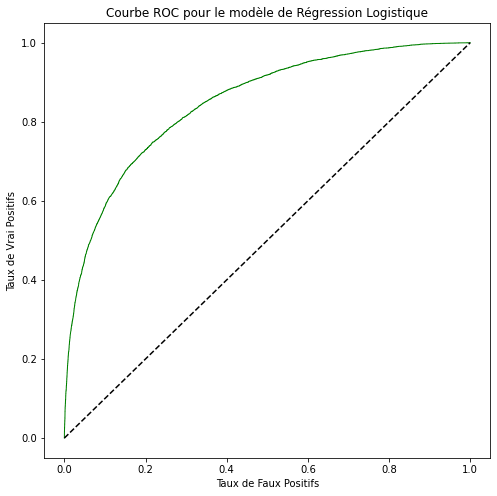

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, '-g', linewidth=1, label='Modèle gcv_lr (auc=%0.2f)' %roc_auc)
plt.plot([0,1], [0,1], 'k--', label='Aléatoire (auc=0.5)')
plt.title('Courbe ROC pour le modèle de Régression Logistique')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrai Positifs')
plt.legend(loc="lower right");


- La courbe ROC est l'outil idéal pour résumer la performance d'un classifieur binaire en fonction de tous les seuils possibles. Elle évite un long travail de prédictions de classes pour différents seuils, et d'évaluation de la matrice de confusion pour chacun de ces seuils.
- Graphiquement, la mesure ROC est représentée sous la forme d'une courbe qui donne le taux de vrais positifs (la sensibilité), en fonction du taux de faux positifs (l'antispécificité).
- Plus la courbe se rapproche du point (0,1), meilleures sont les prédictions. Un modèle avec une sensibilité et une spécificité égales à 1 est considéré comme parfait.



## Forêts Aléatoires

In [ ]:
# définition du modèle
clf_rf  = RandomForestClassifier() # les forêts aléatoires ne gèrent pas les variables qualitatives

param_grid_rf  = [{'n_estimators' : [10, 50, 100],
                   'min_samples_leaf' : np.arange(1,6,1),
                   'max_features' : ['sqrt', 'log2']}]

gcv_rf = GridSearchCV(clf_rf, param_grid_rf)

In [ ]:
start_time = time.time()

# entraînement (~ 7 min.)
gcv_rf.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_rf.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_rf.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_rf.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_rf.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 50} 

Accuracy Score: 0.7771503657930251 

Train Data Score: 0.8923089254939682
Test Data Score: 0.7771503657930251

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            17209  4699
1             1576  4674
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     21908
           1       0.50      0.75      0.60      6250

    accuracy                           0.78     28158
   macro avg       0.71      0.77      0.72     28158
weighted avg       0.82      0.78      0.79     28158

Running Time: 0:07:26.048797


- la méthode de forêt aléatoire fait l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.75.
- la spécificité (taux de vrais négatifs) vaut 0.79.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.85).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.60).

In [ ]:
cv_scores = cross_val_score(gcv_rf, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.76752435 0.76716364 0.76367681]
Average cross-validation score: 0.7661215983327322


- Le score de la méthode des forêts aléatoires est en moyenne de : 0.77.

In [ ]:
# probabilités pour X_test_scaled d'appartenir à chacune des deux classes
y_probas = gcv_rf.predict_proba(X_test_scaled)

In [ ]:
# courbe de gain cumulée
# skplt.metrics.plot_cumulative_gain(y_test, y_probas)

- L'axe horizontal représente les individus de l'échantillon test.
- L'axe vertical représente la variable cible 'RainTomorrow'.

## Support Vector Machine

In [ ]:
# définition du modèle
clf_svm = svm.SVC()

# le temps de calcul est élevé lors d'une régularisation des paramètres de la fonction noyau
param_grid_svm = {'kernel' : ['rbf','linear','poly'],
                  'gamma' : [0.001, 0.1, 0.5]}

gcv_svm = GridSearchCV(clf_svm, param_grid_svm)

In [ ]:
start_time = time.time()

# entraînement (~ 1h)
grille = gcv_svm.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_svm.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_svm.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_svm.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_svm.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'gamma': 0.5, 'kernel': 'rbf'} 

Accuracy Score: 0.7854606151005042 

Train Data Score: 0.7740771912949381
Test Data Score: 0.7854606151005042

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            17436  4472
1             1569  4681
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     21908
           1       0.51      0.75      0.61      6250

    accuracy                           0.79     28158
   macro avg       0.71      0.77      0.73     28158
weighted avg       0.83      0.79      0.80     28158

Running Time: 1:10:13.399274


- la méthode SVM ne fait pas l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.76.
- la spécificité (taux de vrais négatifs) vaut 0.79.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.85).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.61).

In [ ]:
cv_scores = cross_val_score(gcv_svm, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.76656246 0.76950824 0.76313575]
Average cross-validation score: 0.7664021482104925


- Le score de la méthode SVM est en moyenne de : 0.77.

In [ ]:
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params','mean_test_score']])

                                 params  mean_test_score
0     {'gamma': 0.001, 'kernel': 'rbf'}         0.762174
1  {'gamma': 0.001, 'kernel': 'linear'}         0.761913
2    {'gamma': 0.001, 'kernel': 'poly'}         0.575351
3       {'gamma': 0.1, 'kernel': 'rbf'}         0.764859
4    {'gamma': 0.1, 'kernel': 'linear'}         0.761913
5      {'gamma': 0.1, 'kernel': 'poly'}         0.739269
6       {'gamma': 0.5, 'kernel': 'rbf'}         0.766783
7    {'gamma': 0.5, 'kernel': 'linear'}         0.761913
8      {'gamma': 0.5, 'kernel': 'poly'}         0.740211


In [ ]:
# courbe d'apprentissage du modèle (prend beaucoup trop de temps)
# train_sizes, train_scores, valid_scores = learning_curve(svm.SVC(kernel='linear', C=1), data, target, train_sizes=[50, 80, 110, 140], cv=5)
# plt.xlabel("Training examples")
# plt.ylabel("Score")

# train_sizes = [50, 70, 80, 100, 110, 118]
# train_sizes, train_scores, test_scores = learning_curve(gcv_svm, data, target, n_jobs=4, train_sizes=train_sizes)

# train_score_mean = np.mean(train_scores, axis=1)
# train_score_std = np.std(train_scores, axis=1)
# test_score_mean = np.mean(test_scores, axis=1)
# test_score_std = np.std(test_scores, axis=1)

# plt.grid()
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
# plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# plt.legend(loc="best");

## K-plus proches voisins

In [ ]:
# définition du modèle
clf_knn = neighbors.KNeighborsClassifier()

param_grid_knn = {'n_neighbors' : np.arange(1,41,1),
                  'metric' : ['minkowski','manhattan','chebyshev']}

gcv_knn = GridSearchCV(clf_knn, param_grid_knn)

In [ ]:
start_time = time.time()

# entraînement (~ 8 min.)
gcv_knn.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_knn.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_knn.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_knn.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_knn.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'metric': 'manhattan', 'n_neighbors': 39} 

Accuracy Score: 0.7780382129412601 

Train Data Score: 0.77443789828063
Test Data Score: 0.7780382129412601

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            17232  4676
1             1574  4676
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     21908
           1       0.50      0.75      0.60      6250

    accuracy                           0.78     28158
   macro avg       0.71      0.77      0.72     28158
weighted avg       0.82      0.78      0.79     28158

Running Time: 0:08:57.271090


- la méthode des K-plus proches voisins ne fait pas l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.74.
- la spécificité (taux de vrais négatifs) vaut 0.80.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.85).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.60).

In [ ]:
cv_scores = cross_val_score(gcv_knn, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.76505952 0.76115186 0.76091139]
Average cross-validation score: 0.7623742535369323


- Le score de la méthode KNN est en moyenne de : 0.76.

In [ ]:
# scores de 3 modèles utilisant respectivement les matrices de Minkowski, Manhattan et Chebyshev pour des valeurs de k allant de 1 à 40
score_minko = []
score_man = []
score_cheb = []

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_scaled, y_train)
  score_minko.append(knn.score(X_test_scaled, y_test))

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='manhattan')
  knn.fit(X_train_scaled, y_train)
  score_man.append(knn.score(X_test_scaled, y_test))

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
  knn.fit(X_train_scaled, y_train)
  score_cheb.append(knn.score(X_test_scaled, y_test))

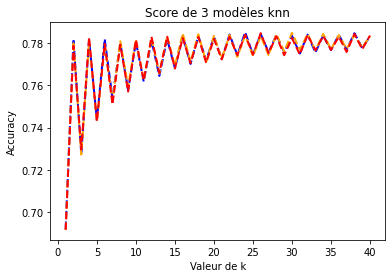

In [ ]:
# affichage des listes crées en fonction de k
plt.title("Score de 3 modèles knn")
plt.plot(range(1,41), score_minko, color='blue', linestyle='dashed', lw=2, label='Minkowski')
plt.plot(range(1,41), score_man, color='orange', linestyle='dashed', lw=2, label='Manhattan')
plt.plot(range(1,41), score_cheb, color='red', linestyle='dashed', lw=2, label='Chebyshev')
plt.xlabel("Valeur de k")
plt.ylabel("Accuracy")
plt.legend;

## Arbres de décision

In [ ]:
# définition du modèle
clf_dt = DecisionTreeClassifier()

param_grid_dt = {'criterion' : ['entropy','gini'], 
                 'max_depth' : np.arange(2,6,1)}

gcv_dt = GridSearchCV(clf_dt, param_grid_dt)

In [ ]:
start_time = time.time()

# entraînement (~ 8 min.)
gcv_dt.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_dt.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_dt.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_dt.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_dt.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print(classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres : {'criterion': 'gini', 'max_depth': 5} 

Accuracy Score: 0.764756019603665 

Train Data Score: 0.7565428239349125
Test Data Score: 0.764756019603665

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            16902  5006
1             1618  4632
              precision    recall  f1-score   support

           0       0.91      0.77      0.84     21908
           1       0.48      0.74      0.58      6250

    accuracy                           0.76     28158
   macro avg       0.70      0.76      0.71     28158
weighted avg       0.82      0.76      0.78     28158

Running Time: 0:00:02.169864


- la méthode des arbres de décision ne fait pas l'objet de sur-apprentissage.
- la sensibilité (taux de vrais positifs) vaut 0.74.
- la spécificité (taux de vrais négatifs) vaut 0.77.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est bon (0.84).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.58).

In [ ]:
# importance des variables
clf_dt = gcv_dt.best_estimator_
clf_dt.fit(X_train_scaled,y_train)

feats = {}
for feature, importance in zip(df.columns, clf_dt.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'Importance'})
importances.sort_values(by='Importance', ascending=False).head(8)

,Importance
Humidity3pm,0.771180
WindGustSpeed,0.128577
Pressure9am,0.056913
Rainfall,0.043147
Temp_Delta_MinMax,0.000183
RainTomorrow,0.000000


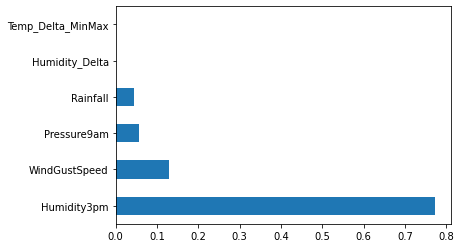

In [ ]:
# importance des variables
feature_imp = pd.Series(clf_dt.feature_importances_,index=data.columns)
feature_imp.nlargest(10).plot(kind='barh');

In [ ]:
cv_scores = cross_val_score(gcv_dt, X_train_scaled, y_train, cv=3, scoring='accuracy')

print('Cross-validation scores:{}'.format(cv_scores))
print('Average cross-validation score: {}'.format(cv_scores.mean()))

Cross-validation scores:[0.7538776  0.7555609  0.74810629]
Average cross-validation score: 0.7525149292613523


- Le score de la méthode DT est en moyenne de : 0.74.